# **Download and Prepare Dataset using kaggle**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!/opt/bin/nvidia-smi
!nvcc --version

Sun Apr 18 20:29:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle

In [ ]:
!mkdir kaggle

In [ ]:
import json
token = {"username":"sabainaharoon","key":"57888015093f26480082ffa56c7cd3fd"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir data
!kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p data

100% 5.20G/5.20G [01:50<00:00, 37.2MB/s]
100% 5.20G/5.20G [01:50<00:00, 50.5MB/s]


In [ ]:
# Unzip the whole zipfile into /content/data
#!unzip -o data/skin-cancer-mnist-ham10000.zip -d data
# Quietly unzip the image files
!unzip -o -q -j data/skin-cancer-mnist-ham10000.zip -d data
!echo files in /content/data: `ls data | wc -l`

files in /content/data: 10021


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o -q -j drive/MyDrive/skin-cancer-mnist-ham10000.zip -d data
!echo files in /content/data: `ls data | wc -l`

files in /content/data: 10020


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import imageio
import os
import pandas as pd
import torch.nn.functional as F

In [ ]:
import torch
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
print(torch.__version__)
#print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))



1.8.1+cu101


# **Preparing Category Folders for torch.utils.data.DataLoader**

---



In [ ]:
import os
import shutil

data_dir = os.getcwd() + "/data/"
dest_dir = data_dir + "test/"
metadata = pd.read_csv(data_dir + '/HAM10000_metadata.csv')

os.mkdir(dest_dir)

label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
label_images = []

for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = metadata[metadata['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]

In [ ]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
data_dir = os.getcwd() + "/data/"
dest_dir = data_dir + "test/"
metadata = pd.read_csv(data_dir + '/HAM10000_metadata.csv')
classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype = np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    print('count of each class', counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight = estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i], ":", classweight[i])

count of each class [ 327.  514. 1099.  115. 1113. 6705.  142.]
akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


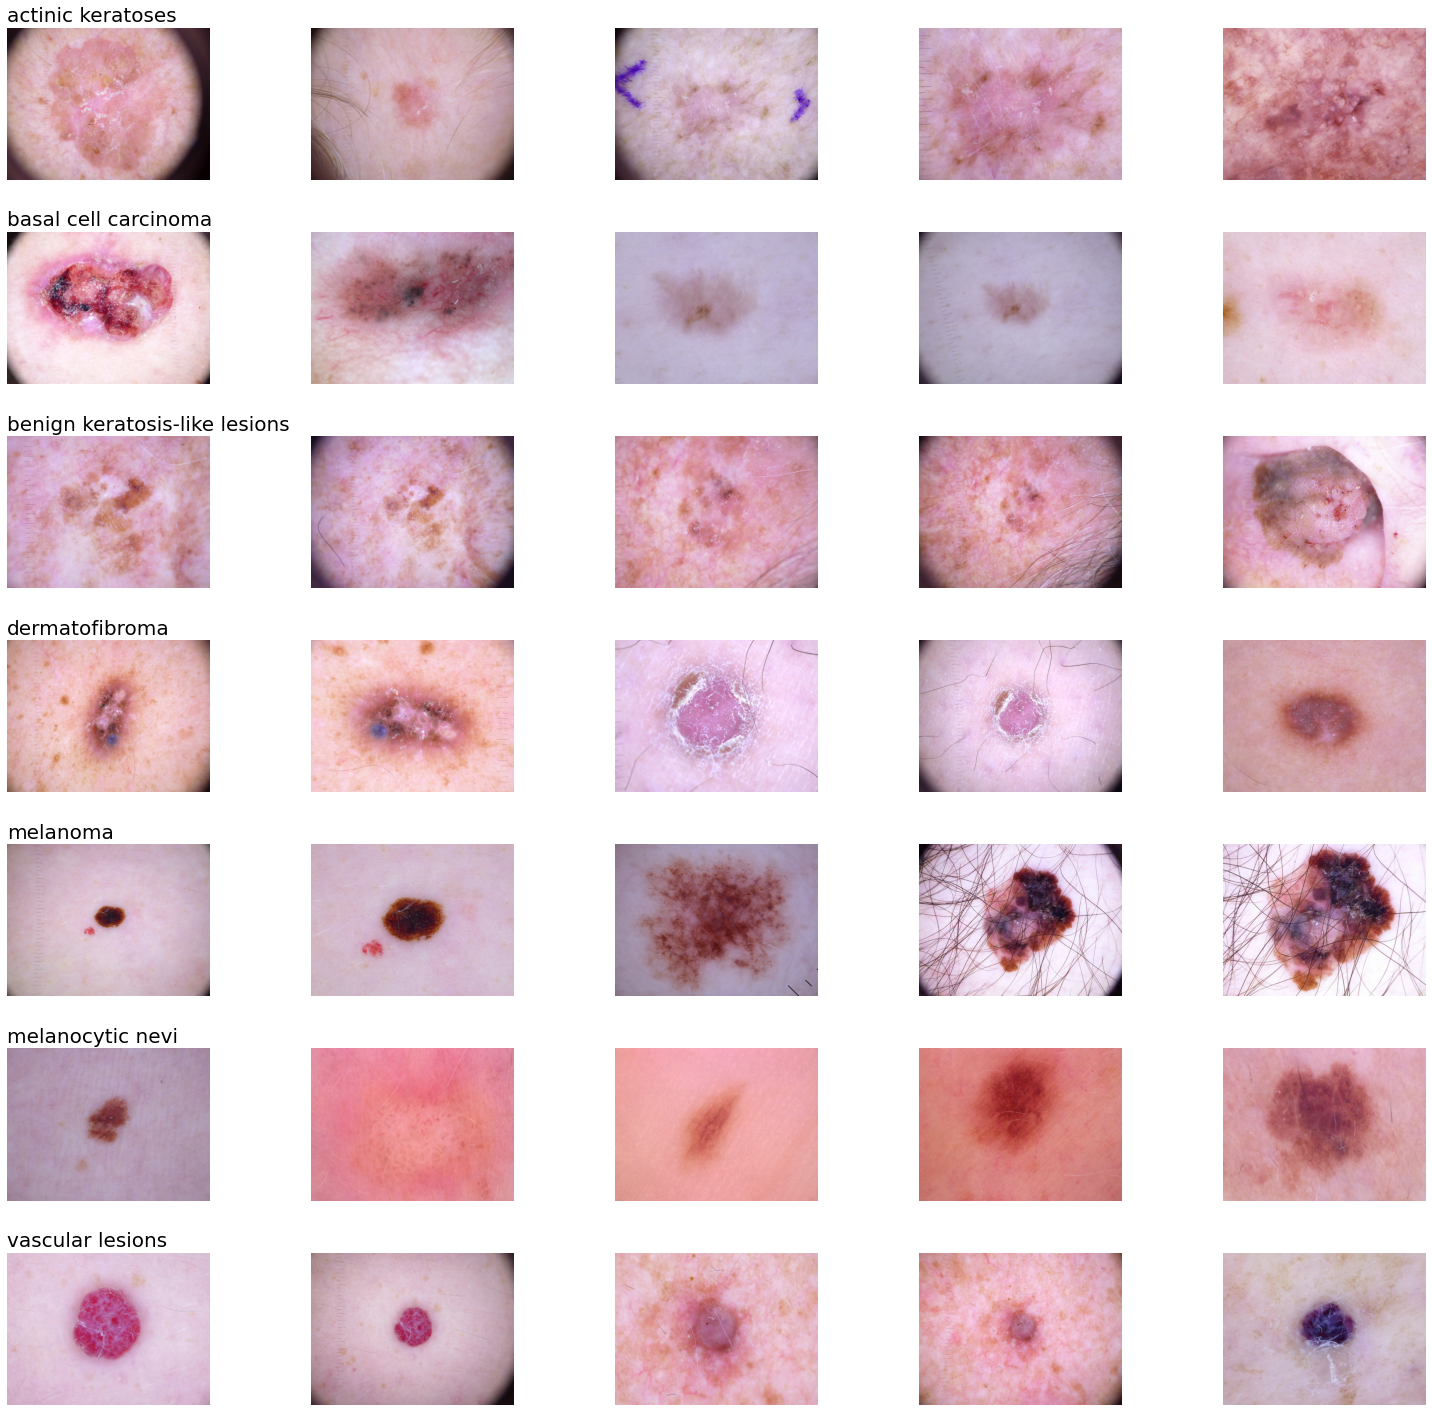

In [ ]:
#visualizing the images

label = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
label_images = []
classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']

fig = plt.figure(figsize=(20,20))
k = range(7)

for i in label:
    sample = metadata[metadata['dx']==i]['image_id'][:5]
    label_images.extend(sample)
    
for position,ID in enumerate(label_images):
    labl = metadata[metadata['image_id']==ID]['dx']
    im_sample = data_dir + '/' + ID + '.jpg'
    im_sample = imageio.imread(im_sample)
    
    plt.subplot(7,5,position+1)
    plt.imshow(im_sample)
    plt.axis('off')
    
    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=20)
        
plt.tight_layout()
plt.show()
    

# **DataLoader** **Code** **Section**





---






In [ ]:
#data_dir = os.getcwd() + "/data/"

# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

# for densenet recommended weights
# norm_mean = (0.485, 0.456, 0.406)
# norm_std = (0.229, 0.224, 0.225)

batch_size = 10
validation_batch_size = 10

# We compute the weights of individual classes and convert them to tensors
class_weights = estimate_weights_mfb(label)
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
    ])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])
                                    

count of each class [ 327.  514. 1099.  115. 1113. 6705.  142.]


In [ ]:
import torchvision
import torch
import os
import numpy as np

test_size = 0.2
val_size = 0.2


# dest_dir = os.getcwd() + "/HAM10K"

class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError


class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """

    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np

        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = torch.randn(self.class_vector.size(0), 2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

data_dir = os.getcwd() + "/data/"
dest_dir = data_dir + "test/"
dataset = torchvision.datasets.ImageFolder(root=dest_dir)
data_label = [s[1] for s in dataset.samples]
print(torch.FloatTensor(data_label), 'jjjj')
print(test_size, "llll")
ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()


# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler
train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
# train_indices = np.load(dest_dir + 'ind_train.npy')
# val_indices = np.load(dest_dir + 'ind_val.npy')
# test_indices = np.load(dest_dir + 'ind_test.npy')
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 6409
Test Data Size: 2003
Validation Data Size: 1603


In [ ]:
# np.save(val_dir + 'ind_train.npy',indices["train"])
# np.save(val_dir + 'ind_test.npy',indices["test"])
# np.save(val_dir + 'ind_val.npy',indices["val"])

In [ ]:
# train_indices = np.load(dest_dir + 'ind_train.npy')
# val_indices = np.load(dest_dir + 'ind_val.npy')
# test_indices = np.load(dest_dir + 'ind_test.npy')

In [ ]:
import torchvision
import torch
import os
import numpy as np

test_size = 0.2
val_size = 0.2

SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= dest_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=4, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= dest_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=test_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


basal cell carcinoma,  melanocytic nevi,  melanoma,  melanoma,  dermatofibroma,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi, 


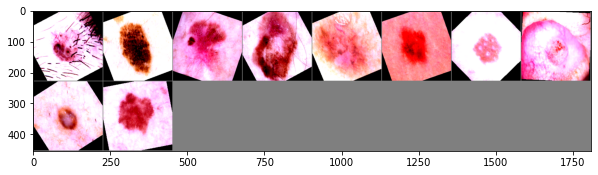

In [ ]:
# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

# **Training and Testing for LENET** 

---



In [ ]:
from torch import nn
import torch.nn.functional as F

num_classses = len(classes)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1 = nn.Linear(16*54*54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classses)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
import torch.optim as optim
net = LeNet()

if torch.cuda.is_available():
    net.cuda()
    
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [ ]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct = 0, 0
    batch_len = labels.size(0)
    correct = (predicted ==labels).sum().item()
    return batch_len,correct

def evaluate(model, val_loader):
    losses = 0
    num_samples_total = 0
    correct_total = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out,1)
        loss = criterion(out, labels)
        losses += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += b_len
        correct_total+=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy
    

In [ ]:
# number of loops over the dataset
num_epochs = 30
accuracy = []
val_accuracy = []
losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total = 0.0
    num_sample_total = 0.0
    
    for i,data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gratients to zero
        optimizer.zero_grad()
        
        #forward + backword + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # computer accuracy
        _, predicted = torch.max(outputs,1)
        b_len, corr = get_accuracy(predicted,labels)
        num_sample_total += b_len
        correct_total +=corr
        running_loss += loss.item()
        
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_sample_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')
    

In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test images; %d %%' % (100*correct/total))

Accuracy of the network on the test images; 58 %


In [ ]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1
            
cm = confusion_matrix.numpy()

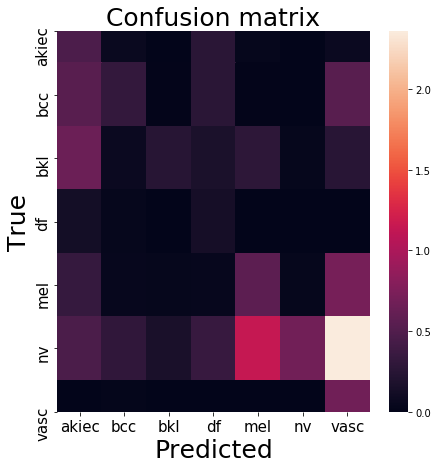

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm/(cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

#labels , title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25);
ax.set_title('Confusion matrix', size=25);
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);

In [ ]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

Generating Grad-CAM @conv2
	#0: melanocytic nevi (0.31507)


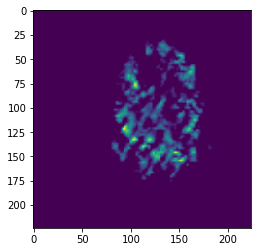

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  melanocytic nevi


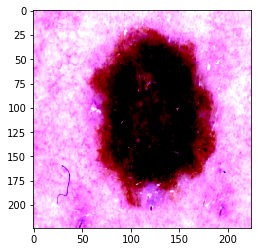

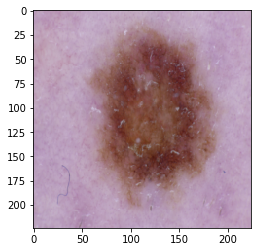

In [ ]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["conv2"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

# **Transfer Learning**

---


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

## **DenseNet Evaluation**

---



In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
DenseNet_ = torchvision.models.densenet121(pretrained=True)

# replace last layer of resnet to amtch our number of classes which is 7
DenseNet_.classifier = nn.Linear(1024, num_classes)
DenseNet_ = DenseNet_.to(device)

In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(DenseNet_.parameters(), lr=1e-6)
print(DenseNet_)

In [ ]:
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []

max_accuracy = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = DenseNet_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    if epoch % 10:
      path = os.path.join(dest_dir, 'net_DenseNet__e-6_last.pth')
      torch.save(DenseNet_, path)

    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(DenseNet_, validation_data_loader)

    # if val_acc > max_accuracy:
    #   print('saving highest accuracy model')
    #   max_accuracy = val_acc
    #   path = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'net_DenseNet_sameindices.pth')
    #   torch.save(DenseNet_, path)
    
    print('Epoch: %d' %(epoch))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

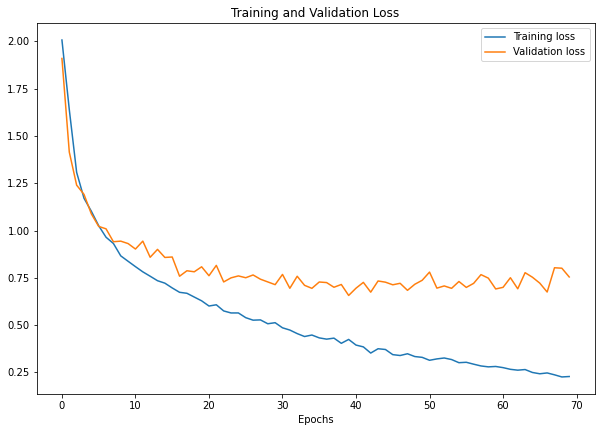

<Figure size 432x288 with 0 Axes>

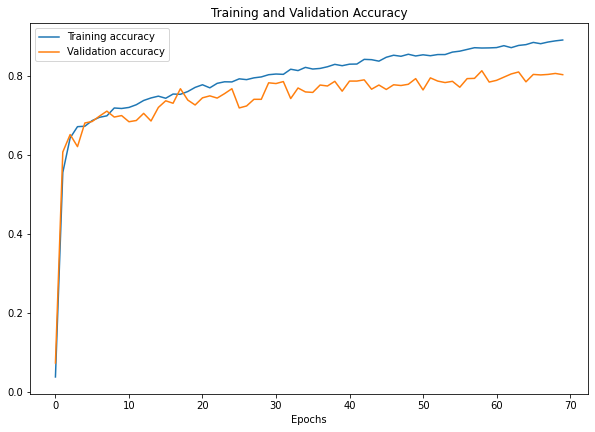

<Figure size 432x288 with 0 Axes>

In [ ]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot( losses, label='Training loss')
plt.plot( val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot( accuracy, label='Training accuracy')
plt.plot( val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [ ]:
densenet121 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_DenseNet_sameindices.pth')
densenet121 = densenet121.to(device)

Accuracy of the network on the test images: 0.834748 %
Accuracy of the network on the test images: 0.718910 %
Accuracy of actinic keratoses :  64 %
Accuracy of basal cell carcinoma :  72 %
Accuracy of benign keratosis-like lesions :  67 %
Accuracy of dermatofibroma :  60 %
Accuracy of melanoma :  55 %
Accuracy of melanocytic nevi :  92 %
Accuracy of vascular lesions :  89 %


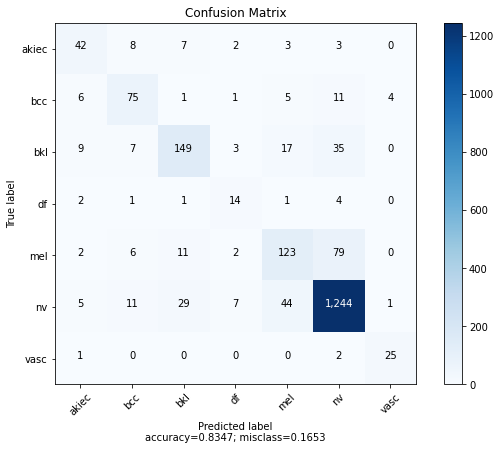

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))

densenet121.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = densenet121(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %3f %%' % (
     correct / total))

mca = 0
for i in range(len(classes)):
        mca = mca + (class_correct[i] / class_total[i])
print('Accuracy of the network on the test images: %3f %%' % (
     mca / len(classes)))

for i in range(len(classes)):
    print('Accuracy of %3s : %3d %%' % (
        classes[i], 100* class_correct[i] / class_total[i]))

cm = confusion_matrix.numpy()

plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

## **ResNEXT101 evaluation & Results**

---



In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
resnext101 = torchvision.models.resnext101_32x8d(pretrained=True)
#resnext101 = torchvision.models.resnet101(pretrained=True)


# replace last layer of resnet to amtch our number of classes which is 7
resnext101.fc = nn.Linear(2048, num_classes)
resnext101 = resnext101.to(device)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
from torch import nn
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(resnext101.parameters(), lr=1e-6)
print(resnext101)

In [ ]:
# number of loops over the dataset
num_epochs = 200
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnext101(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        #print(predicted)
        #print(labels)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    if epoch % 10:
      path = os.path.join('/content/drive/MyDrive/Colab Notebooks/', 'net_resnext101_sameIndices.pth')
      torch.save(resnext101, path)

    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(resnext101, validation_data_loader)
    
    print('Epoch: %d' %(epoch))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Accuracy of the network on the test images: 0.850724 %
Accuracy of the network on the test images: 0.779607 %
Accuracy of actinic keratoses :  67 %
Accuracy of basal cell carcinoma :  79 %
Accuracy of benign keratosis-like lesions :  77 %
Accuracy of dermatofibroma :  73 %
Accuracy of melanoma :  66 %
Accuracy of melanocytic nevi :  90 %
Accuracy of vascular lesions :  89 %


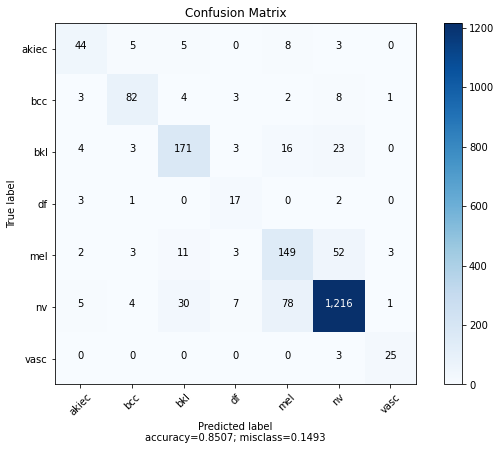

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


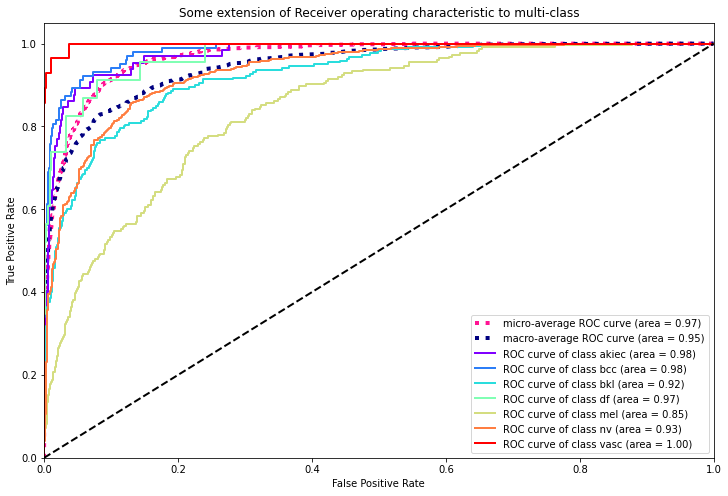

In [ ]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm
# calculate false positive rate and true positive rate for all thresholds of classification
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))
n_classes = len(classes)
y_test = [] 
preds = []

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        y_test.append(label_binarize(labels.cpu().detach().numpy(), classes=[0,1,2,3,4,5,6]))
        images, labels = images.to(device), labels.to(device)
        # outputs =  (1/4.0)*(resnext101(images) + densenet121(images) + resnet152(images))
        # outputs = (1/7.0)*(resnext101(images) +
        #                      resnet18(images) + densenet121(images) + resnet50(images)
        #                      + resnet34(images) + DenseNet201(images) + resnet152(images))

        outputs = resnext101(images)
                             
        _, predicted = torch.max(outputs.data, 1)
        preds.append(outputs.cpu().detach().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %3f %%' % (
     correct / total))

mca = 0
for i in range(len(classes)):
        mca = mca + (class_correct[i] / class_total[i])
print('Accuracy of the network on the test images: %3f %%' % (
     mca / len(classes)))

for i in range(len(classes)):
    print('Accuracy of %3s : %3d %%' % (
        classes[i], 100* class_correct[i] / class_total[i]))

c_m = confusion_matrix.numpy()

plot_confusion_matrix(c_m.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

preds = np.concatenate(preds, axis=0)
y_test = np.concatenate(y_test, axis=0)
target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## **ResNet152 with consistency Regularization**

In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
resnet152 = torchvision.models.resnet152(pretrained = True)

# replace last layer of resnet to amtch our number of classes which is 7
resnet152.fc = nn.Linear(2048, num_classes)
resnet152 = resnet152.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(resnet152.parameters(),lr=1e-5)
print(resnet152)

In [ ]:
def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    return x[tuple(slice(None, None) if i != dim
             else torch.arange(x.size(i)-1, -1, -1).long()
             for i in range(x.dim()))]

In [ ]:
num_epochs = 20
#accuracy = []
#val_accuracy = []
#losses = []
#al_losses = []
len_dataloader = (len(train_indices))/batch_size
total_iterations = num_epochs*len_dataloader + len_dataloader
alph, beta , gamma = ramp_weight(total_iterations)

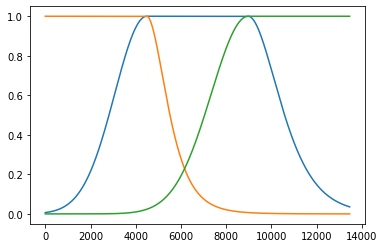

In [ ]:
plt.plot(alph)
plt.plot(beta)
plt.plot(gamma)
plt.show()

In [ ]:
# number of loops over the dataset
num_epochs = 100
accuracy = []
val_accuracy = []
losses = []
val_losses = []
len_dataloader = (len(train_indices))/batch_size
total_iteration = num_epochs*len_dataloader + len_dataloader
beta, alpha , gamma = ramp_weight(total_iteration)
itr = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs_flip = inputs.clone().detach()
        inputs_flip = flip(inputs_flip,3)
        inputs_flip, inputs, labels = inputs_flip.to(device), inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet152(inputs)
        outputs_flip = resnet152(inputs_flip)
        loss_out = criterion(outputs, labels)
        loss_outflip = criterion(outputs_flip, labels)
        cons_loss = -F.cosine_similarity(outputs, outputs_flip).mean()

        w = 1.0/3.0

        loss = alpha[itr]*loss_out + beta[itr]*loss_outflip + gamma[iter]*cons_loss

        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()
        itr = itr + 1

    if epoch % 10:
      path = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'net_resnet152__e-5_flip.pth')
      torch.save(resnet152, path)

    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(resnet152, validation_data_loader)
    
    print('Epoch: %d' %(epoch))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Accuracy of the network on the test images: 87 %
Accuracy of actinic keratoses : 67 %
Accuracy of basal cell carcinoma : 75 %
Accuracy of benign keratosis-like lesions : 77 %
Accuracy of dermatofibroma : 69 %
Accuracy of melanoma : 65 %
Accuracy of melanocytic nevi : 94 %
Accuracy of vascular lesions : 89 %


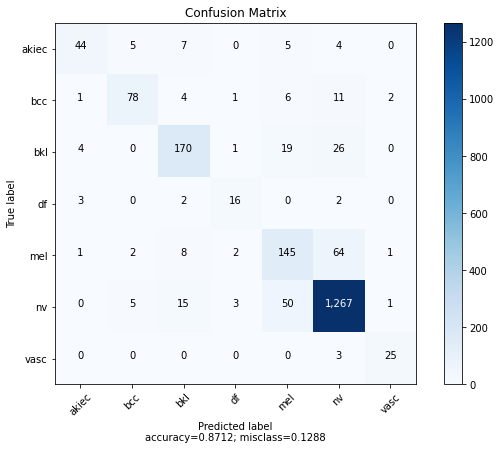

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))

resnet152.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet152(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(labels, "label")
        #print(predicted, "pred")
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cm = confusion_matrix.numpy()

plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

In [ ]:
path = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'net_resnet152__e-5_flip.pth')
torch.save(resnet152, path)

## **Inception v3 Evaluation**

---



In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
inception_v3 = torchvision.models.inception_v3(pretrained=True)

# replace last layer of resnet to amtch our number of classes which is 7
#inception_v3.classifier = nn.Linear(2048, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(768, num_classes)
inception_v3.fc = nn.Linear(2048, num_classes)
inception_v3 = inception_v3.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(inception_v3.parameters(), lr=1e-6)
print(inception_v3)

In [ ]:
# number of loops over the dataset
num_epochs = 40
#accuracy = []
#val_accuracy = []
#losses = []
#val_losses = []
len_dataloader = len(train_data_loader)
total_iterations = num_epochs*len_dataloader + len_dataloader
beta ,alpha,  gamma = ramp_weight(total_iterations)
itr = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs_flip = inputs.clone().detach()
        inputs_flip = flip(inputs_flip,3)
        inputs_flip, inputs, labels = inputs_flip.to(device), inputs.to(device), labels.to(device)
        
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = inception_v3(inputs)
        outputs_flip = inception_v3(inputs_flip)
        loss_out = criterion(outputs, labels)
        loss_outflip = criterion(outputs_flip, labels)
        cons_loss = 1.0 - F.cosine_similarity(outputs, outputs_flip).mean()

        w = 1.0/3.0

        loss = alpha[itr]*loss_out + beta[itr]*loss_outflip + gamma[itr]*cons_loss

        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()
        itr = itr + 1

    if epoch % 10:
      path = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'net_inception_v3__e-6_flipnew.pth')
      torch.save(inception_v3, path)

    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(inception_v3, validation_data_loader)
    
    print('Epoch: %d' %(epoch))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

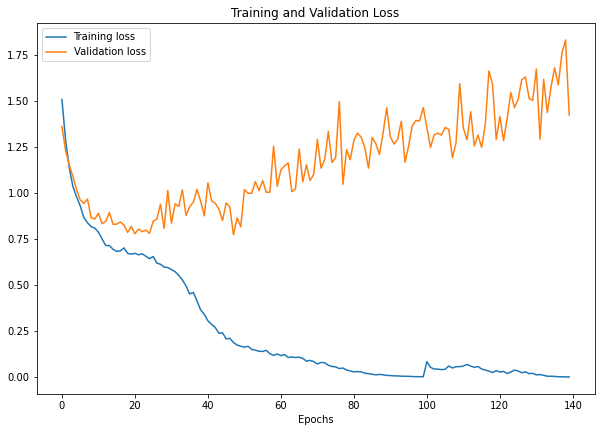

<Figure size 432x288 with 0 Axes>

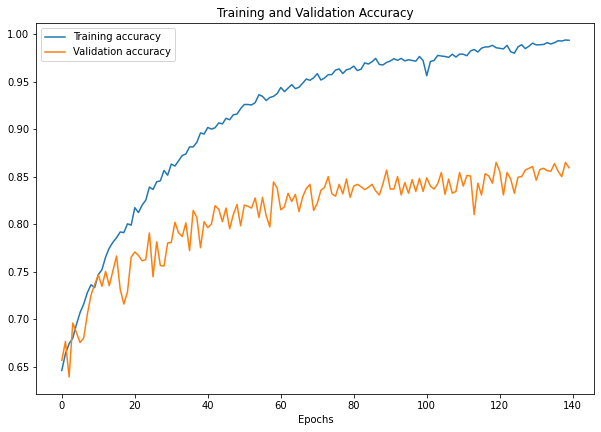

<Figure size 432x288 with 0 Axes>

In [ ]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot( losses, label='Training loss')
plt.plot( val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot( accuracy, label='Training accuracy')
plt.plot( val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

Accuracy of the network on the test images: 84 %
Accuracy of actinic keratoses : 67 %
Accuracy of basal cell carcinoma : 73 %
Accuracy of benign keratosis-like lesions : 69 %
Accuracy of dermatofibroma : 56 %
Accuracy of melanoma : 62 %
Accuracy of melanocytic nevi : 93 %
Accuracy of vascular lesions : 71 %


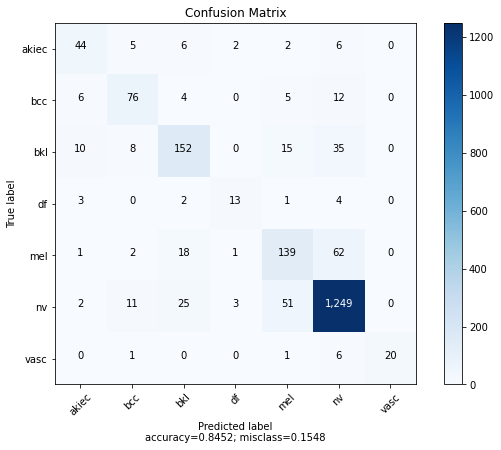

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))

inception_v3.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v3(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(labels, "label")
        #print(predicted, "pred")
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cm = confusion_matrix.numpy()

plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

## **ResNET50 Results**

---



In [ ]:
resnet_50_again = torch.load("/content/data/test/net_resnet50_e-5_againShocked.pth")

Accuracy of the network on the test images: 82 %
Accuracy of actinic keratoses : 52 %
Accuracy of basal cell carcinoma : 74 %
Accuracy of benign keratosis-like lesions : 79 %
Accuracy of dermatofibroma : 52 %
Accuracy of melanoma : 72 %
Accuracy of melanocytic nevi : 87 %
Accuracy of vascular lesions : 92 %


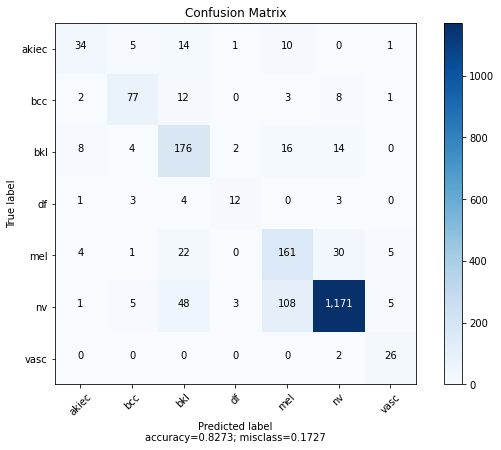

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))

resnet_50_again.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_50_again(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cm = confusion_matrix.numpy()

plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

## **ResNET50 Evaluation**

---



In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
resnet_50 = torchvision.models.resnet50(pretrained = True)

# replace last layer of resnet to amtch our number of classes which is 7
resnet_50.fc = nn.Linear(2048, num_classes)
resnet_50 = resnet_50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(resnet_50.parameters(), lr=1e-5)
print(resnet_50)

In [ ]:
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    if epoch % 10:
      path = os.path.join(dest_dir, 'net_resnet50_e-5_againShocked.pth')
      torch.save(resnet_50, path)

    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(resnet_50, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

## **ResNEt 34 Results**

---



In [ ]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

Accuracy of the network on the test images: 85 %
Accuracy of actinic keratoses : 59 %
Accuracy of basal cell carcinoma : 83 %
Accuracy of benign keratosis-like lesions : 67 %
Accuracy of dermatofibroma : 30 %
Accuracy of melanoma : 70 %
Accuracy of melanocytic nevi : 93 %
Accuracy of vascular lesions : 85 %


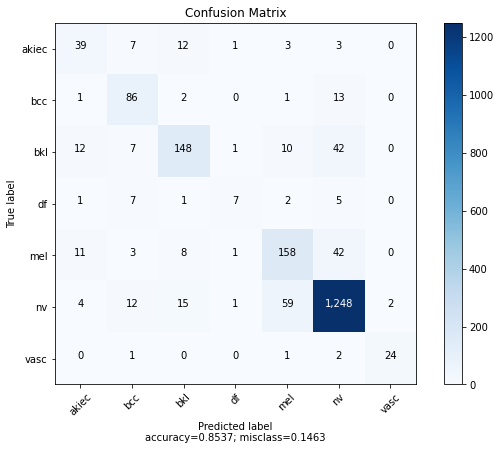

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))

net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cm = confusion_matrix.numpy()

plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

## **ResNET34 Evaluation**

---



In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
net = torchvision.models.resnet34(pretrained = True)

# replace last layer of resnet to amtch our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
#net.fc = nn.Linear(256, num_classes)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

In [ ]:
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    if epoch % 10:
      path = os.path.join(dest_dir, 'net_resnet34_e-5_again.pth')
      torch.save(net, path)
    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

## **Resnet 18 Results**

---



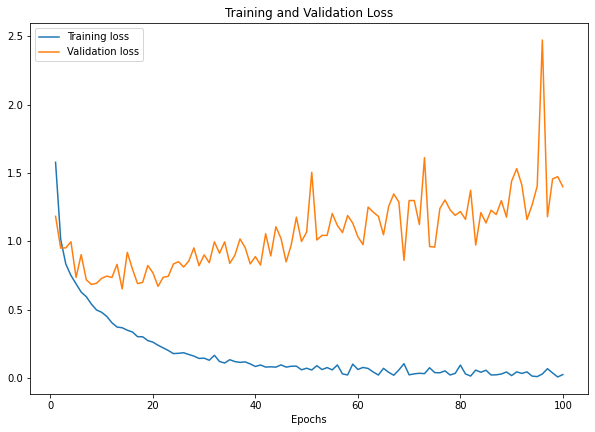

<Figure size 432x288 with 0 Axes>

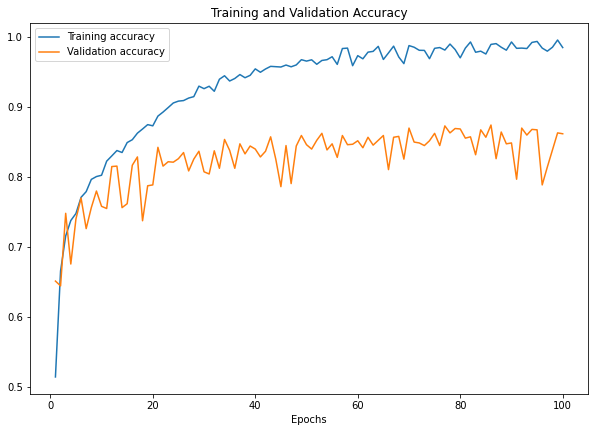

<Figure size 432x288 with 0 Axes>

In [ ]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 85 %


In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 82 %
Accuracy of basal cell carcinoma : 76 %
Accuracy of benign keratosis-like lesions : 60 %
Accuracy of dermatofibroma : 33 %
Accuracy of melanoma : 71 %
Accuracy of melanocytic nevi : 95 %
Accuracy of vascular lesions : 74 %


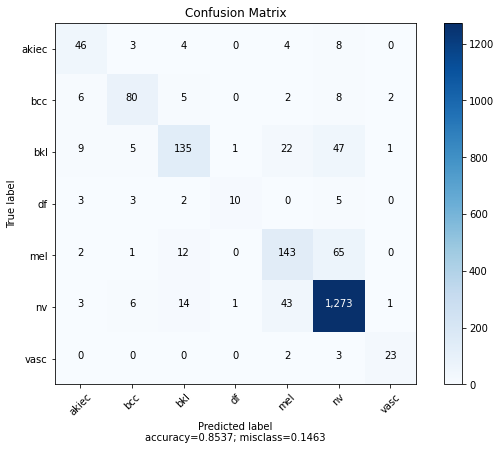

In [ ]:
plot_confusion_matrix(cm.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

In [ ]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

Generating Grad-CAM @layer4
	#0: melanocytic nevi (1.00000)


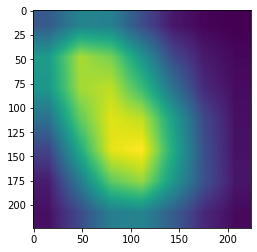

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  melanocytic nevi


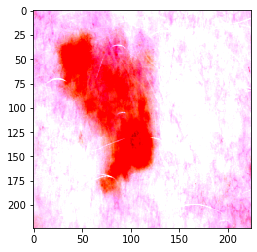

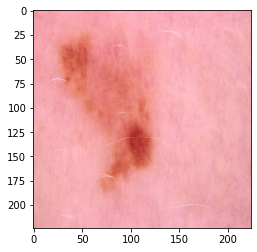

In [ ]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["layer4"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

## **ResNet18 evaluation**


In [ ]:
from torch import nn

import torchvision
import torch
import os
import numpy as np

classes = ['actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions',
          'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
num_classes = len(classes)
net = torchvision.models.resnet18(pretrained = True)

# replace last layer of resnet to amtch our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

In [ ]:
# number of loops over the dataset
num_epochs = 100
accuracy = []
val_accuracy = []
losses = []
val_losses = [] 


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    if epoch % 10:
      path = os.path.join(dest_dir, 'net_resnet18_e-5.pth')
      torch.save(net, path)
    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

## **Ensemble of 3 models**

---



In [ ]:
resnet18 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet18_sameindices.pth')
resnet34 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet34_sameindices.pth')
resnet50 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet50_sameindices.pth')
densenet121 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_DenseNet_sameindices.pth')
DenseNet201 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_DenseNet201__e-6_flip.pth')
resnet152 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet152__e-5_flip.pth')
resnet101 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet101_sameIndices.pth')

resnet152 = resnet152.to(device)
DenseNet201 = DenseNet201.to(device)
resnet18 = resnet18.to(device)
Resnet34 = resnet34.to(device)
resnet50 = resnet50.to(device)
densenet121 = densenet121.to(device)

Accuracy of the network on the test images: 0.890664 %
Accuracy of the network on the test images: 0.802357 %
Accuracy of actinic keratoses :  72 %
Accuracy of basal cell carcinoma :  81 %
Accuracy of benign keratosis-like lesions :  80 %
Accuracy of dermatofibroma :  73 %
Accuracy of melanoma :  68 %
Accuracy of melanocytic nevi :  95 %
Accuracy of vascular lesions :  89 %


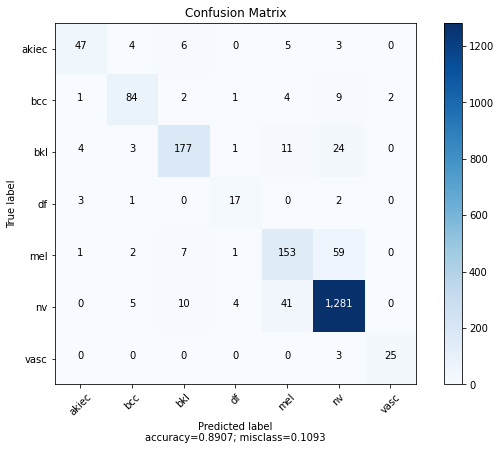

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


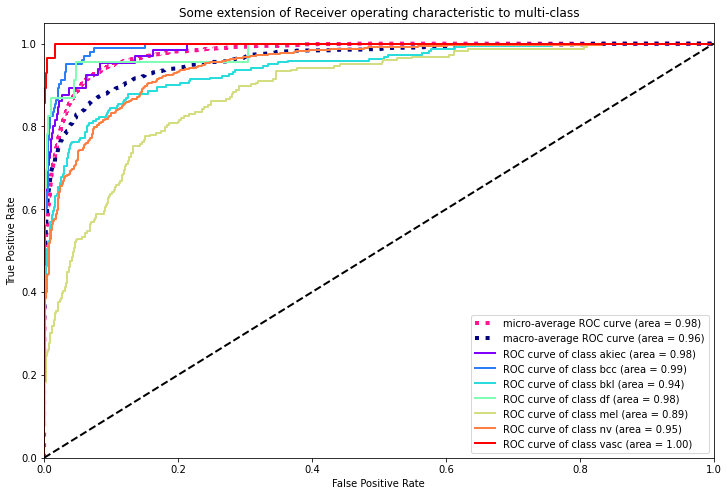

In [ ]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm
# calculate false positive rate and true positive rate for all thresholds of classification
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))
n_classes = len(classes)
y_test = [] 
preds = []

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        y_test.append(label_binarize(labels.cpu().detach().numpy(), classes=[0,1,2,3,4,5,6]))
        images, labels = images.to(device), labels.to(device)
        outputs =  (1/3.0)*(resnext101(images) + densenet121(images) + resnet152(images))
        # outputs = (1/7.0)*(resnext101(images) +
        #                      resnet18(images) + densenet121(images) + resnet50(images)
        #                      + resnet34(images) + DenseNet201(images) + resnet152(images))

        # outputs = resnext101(images)
                             
        _, predicted = torch.max(outputs.data, 1)
        preds.append(outputs.cpu().detach().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %3f %%' % (
     correct / total))

mca = 0
for i in range(len(classes)):
        mca = mca + (class_correct[i] / class_total[i])
print('Accuracy of the network on the test images: %3f %%' % (
     mca / len(classes)))

for i in range(len(classes)):
    print('Accuracy of %3s : %3d %%' % (
        classes[i], 100* class_correct[i] / class_total[i]))

c_m = confusion_matrix.numpy()

plot_confusion_matrix(c_m.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

preds = np.concatenate(preds, axis=0)
y_test = np.concatenate(y_test, axis=0)
target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## **Ensemble of 7 models**

---



In [ ]:
resnet18 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet18_sameindices.pth')
resnet34 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet34_sameindices.pth')
resnet50 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet50_sameindices.pth')
densenet121 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_DenseNet_sameindices.pth')
DenseNet201 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_DenseNet201__e-6_flip.pth')
resnet152 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet152__e-5_flip.pth')
resnet101 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet101_sameIndices.pth')

resnet152 = resnet152.to(device)
DenseNet201 = DenseNet201.to(device)
resnet18 = resnet18.to(device)
Resnet34 = resnet34.to(device)
resnet50 = resnet50.to(device)
densenet121 = densenet121.to(device)

Accuracy of the network on the test images: 0.894159 %
Accuracy of the network on the test images: 0.801750 %
Accuracy of actinic keratoses :  78 %
Accuracy of basal cell carcinoma :  83 %
Accuracy of benign keratosis-like lesions :  76 %
Accuracy of dermatofibroma :  65 %
Accuracy of melanoma :  72 %
Accuracy of melanocytic nevi :  95 %
Accuracy of vascular lesions :  89 %


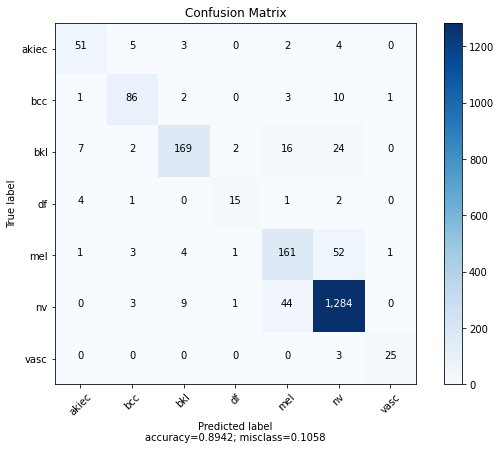

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


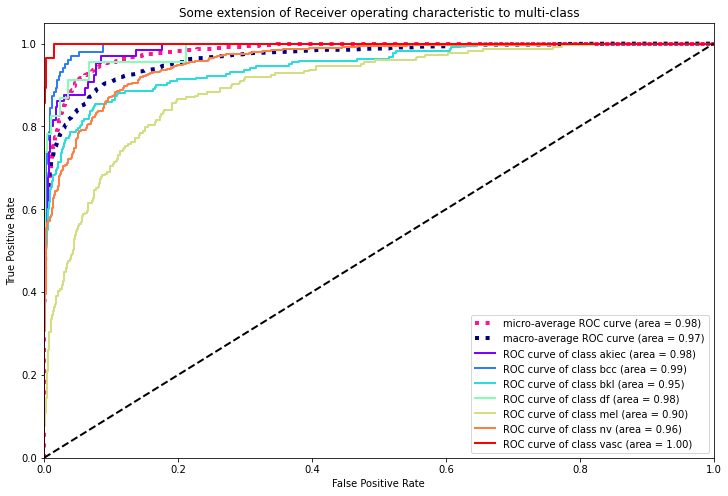

In [ ]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm
# calculate false positive rate and true positive rate for all thresholds of classification
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))
n_classes = len(classes)
y_test = [] 
preds = []

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        y_test.append(label_binarize(labels.cpu().detach().numpy(), classes=[0,1,2,3,4,5,6]))
        images, labels = images.to(device), labels.to(device)
        outputs = (1/7.0)*(resnext101(images) +
                             resnet18(images) + densenet121(images) + resnet50(images)
                             + resnet34(images) + DenseNet201(images) + resnet152(images))

                             
        _, predicted = torch.max(outputs.data, 1)
        preds.append(outputs.cpu().detach().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %3f %%' % (
     correct / total))

mca = 0
for i in range(len(classes)):
        mca = mca + (class_correct[i] / class_total[i])
print('Accuracy of the network on the test images: %3f %%' % (
     mca / len(classes)))

for i in range(len(classes)):
    print('Accuracy of %3s : %3d %%' % (
        classes[i], 100* class_correct[i] / class_total[i]))

c_m = confusion_matrix.numpy()

plot_confusion_matrix(c_m.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

preds = np.concatenate(preds, axis=0)
y_test = np.concatenate(y_test, axis=0)
target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# **Validation isic 2018 set testing for Ensemble**

In [ ]:
val_dir = (data_dir + "validation/")
os.mkdir(val_dir)

In [ ]:
!unzip -o -q -j data/validation/ISIC2018_Task3_Validation_GroundTruth.zip -d data/validation 
!unzip -o -q -j data/validation/ISIC2018_Task3_Validation_Input.zip -d data/validation
!echo files in /data/validation: `ls data/validation | wc -l`

files in /data/validation: 198


In [ ]:
import os
import shutil

metadata = pd.read_csv(val_dir + '/ISIC2018_Task3_Validation_GroundTruth.csv')

label = ['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']
label_images = []

for i in label:
    os.mkdir(val_dir + str(i) + "/")
    sample = metadata[metadata[i] == 1]['image']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((val_dir + "/"+ id +".jpg"), (val_dir + i + "/"+id+".jpg"))
    label_images=[]

In [ ]:
dataset_val = torchvision.datasets.ImageFolder(root= val_dir, transform=transform_test)
validation_data_loader_isic = torch.utils.data.DataLoader(dataset_val, batch_size=validation_batch_size, shuffle=False)

## **Ensemble Performance for validation set isic 2018**

Accuracy of the network on the test images: 0.875648 %
Accuracy of the network on the test images: 0.809712 %
Accuracy of actinic keratoses :  75 %
Accuracy of basal cell carcinoma :  86 %
Accuracy of benign keratosis-like lesions :  72 %
Accuracy of dermatofibroma : 100 %
Accuracy of melanoma :  71 %
Accuracy of melanocytic nevi :  94 %
Accuracy of vascular lesions :  66 %


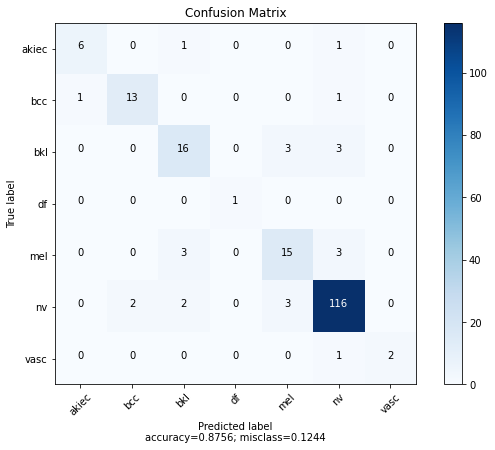

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


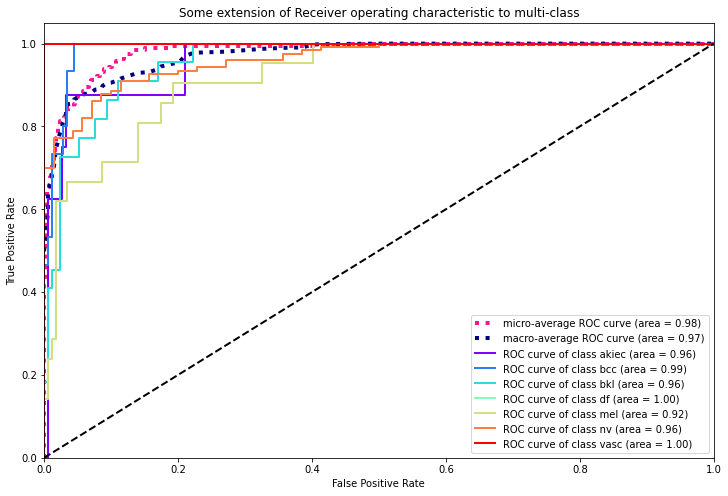

In [ ]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm
# calculate false positive rate and true positive rate for all thresholds of classification
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = torch.zeros(len(classes), len(classes))
n_classes = len(classes)
y_test = [] 
preds = []
with torch.no_grad():
    for data in validation_data_loader_isic:
        images, labels = data
        y_test.append(label_binarize(labels.cpu().detach().numpy(), classes=[0,1,2,3,4,5,6]))
        images, labels = images.to(device), labels.to(device)
        outputs =  (1/3.0)*(resnext101(images) + densenet121(images) + resnet152(images))
                             
        _, predicted = torch.max(outputs.data, 1)
        preds.append(outputs.cpu().detach().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the test images: %3f %%' % (
     correct / total))

mca = 0
for i in range(len(classes)):
        mca = mca + (class_correct[i] / class_total[i])
print('Accuracy of the network on the test images: %3f %%' % (
     mca / len(classes)))

for i in range(len(classes)):
    print('Accuracy of %3s : %3d %%' % (
        classes[i], 100* class_correct[i] / class_total[i]))

c_m = confusion_matrix.numpy()

plot_confusion_matrix(c_m.astype(int), 
                      normalize    = False,
                      target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc'],
                      title        = "Confusion Matrix")

preds = np.concatenate(preds, axis=0)
y_test = np.concatenate(y_test, axis=0)
target_names = ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# **Generate Leaderboard predictions**

In [ ]:
!unzip -o -q -j data/isic_test/ISIC2018_Task3_Test_Input.zip -d data/isic_test 
!echo files in /data/isic_test: `ls data/isic_test | wc -l`

files in /data/isic_test: 1515


In [ ]:
from glob import glob

test_dir = '/content/data/isic_test'
test_img_path = glob(os.path.join(test_dir, '*.jpg'))

# get the image id for prediction csv file
imageid_path_dict_test = {os.path.splitext(os.path.basename(x))[0] : x for x in test_img_path}


In [ ]:
from torchvision import transforms
#data_dir = os.getcwd() + "/data/"
# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 10
validation_batch_size = 10


transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])
                                    

In [ ]:
from torch.utils.data import DataLoader,Dataset
from PIL import Image

#dataloader or dataset
class ISIC(Dataset):
    def __init__(self, test_imgpath_dict, transform=None):
        self.test_imgpath_dict = test_imgpath_dict
        self.img_id = list(self.test_imgpath_dict.keys())
        self.transform = transform
    
    def __len__(self):
        return(len(self.test_imgpath_dict))
    
    def __getitem__(self, index):
        
        id_ = self.img_id[index]
        #print(id_, 'hello are you even coming here')
        X = Image.open(self.test_imgpath_dict[id_]) 
        #print(y, self.df['cell_type'][index])
        if self.transform:
            X = self.transform(X)
        return X,id_

In [ ]:
#dataset
test_ds = ISIC(imageid_path_dict_test, transform=transform_test)

batch_size = 1

#dataloader
test_dl = DataLoader(test_ds, batch_size=batch_size,shuffle=False, num_workers=0)

In [ ]:
clas_s  =  ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']

from torch.nn import functional as F
from torch.autograd import Variable

resnext101.eval()
img_ids = []
MEL = []
NV = []
BCC = []
AKIEC = []
BKL = []
DF = []
VASC = []
for i,data in enumerate(test_dl):
        images, img_id = data
        #print('labels', labels)
        n = images.size(0)
        
        images = Variable(images).to(device)
        optimizer.zero_grad()
        outputs = resnext101(images)
        #print(outputs)
        outputs  = F.softmax(outputs, dim=1)
        outputs = outputs.cpu().detach().numpy() 
        img_ids.append(img_id)
        MEL.append((outputs[:,4]))
        NV.append((outputs[:,5]))
        BCC.append((outputs[:,1]))
        AKIEC.append((outputs[:,0]))
        BKL.append((outputs[:,2]))
        DF.append((outputs[:,3]))
        VASC.append((outputs[:,6]))

# flatten the lists
img_ids = [item for sublist in img_ids for item in sublist]
MEL = [item for sublist in MEL for item in sublist]
NV = [item for sublist in NV for item in sublist]
BCC = [item for sublist in BCC for item in sublist]
AKIEC = [item for sublist in AKIEC for item in sublist]
BKL = [item for sublist in BKL for item in sublist]
DF = [item for sublist in DF for item in sublist]
VASC = [item for sublist in VASC for item in sublist]

In [ ]:
path = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'net_DenseNet_sameindices.pth')
densenet = torch.load("/content/drive/MyDrive/Colab Notebooks/net_DenseNet__e-6.pth")

In [ ]:
resnet152 = torch.load("/content/drive/MyDrive/Colab Notebooks/net_resnet152__e-5_flip.pth")

In [ ]:
resnet18 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet18_sameindices.pth')
resnet34 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet34_sameindices.pth')
resnet50 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet50_sameindices.pth')
resnet101 = torch.load('/content/drive/MyDrive/Colab Notebooks/net_resnet101_sameIndices.pth')

In [ ]:
clas_s  =  ['akiec','bcc','bkl','df', 'mel', 'nv','vasc']

from torch.nn import functional as F
from torch.autograd import Variable

# densenet.eval()
# resnet152.eval()
img_ids = []
MEL = []
NV = []
BCC = []
AKIEC = []
BKL = []
DF = []
VASC = []
for i,data in enumerate(test_dl):
        images, img_id = data
        #print('labels', labels)
        n = images.size(0)
        
        images = Variable(images).to(device)
        optimizer.zero_grad()
        # outputs = (1/4.0)*(densenet(images) + resnext101(images) + resnet152(images) + resnet18(images))
        # outputs = (1/6.0)*(resnext101(images) +
        #                      resnet18(images) + densenet(images) + resnet50(images)
        #                      + resnet34(images) + resnet101(images))
        outputs = (1/7.0)*(resnext101(images) +
                             resnet18(images) + densenet121(images) + resnet50(images)
                             + resnet34(images) + DenseNet201(images) + resnet152(images))
        #print(outputs)
        outputs  = F.softmax(outputs, dim=1)
        outputs = outputs.cpu().detach().numpy() 
        img_ids.append(img_id)
        MEL.append((outputs[:,4]))
        NV.append((outputs[:,5]))
        BCC.append((outputs[:,1]))
        AKIEC.append((outputs[:,0]))
        BKL.append((outputs[:,2]))
        DF.append((outputs[:,3]))
        VASC.append((outputs[:,6]))

# flatten the lists
img_ids = [item for sublist in img_ids for item in sublist]
MEL = [item for sublist in MEL for item in sublist]
NV = [item for sublist in NV for item in sublist]
BCC = [item for sublist in BCC for item in sublist]
AKIEC = [item for sublist in AKIEC for item in sublist]
BKL = [item for sublist in BKL for item in sublist]
DF = [item for sublist in DF for item in sublist]
VASC = [item for sublist in VASC for item in sublist]

In [ ]:
submission_df_1 = pd.DataFrame({
                  "image": img_ids, 
                  "MEL": MEL,
                  "NV": NV,
                  "BCC" : BCC,
                  "AKIEC": AKIEC,
                  "BKL": BKL,
                  "DF": DF,
                  "VASC": VASC})
submission_df_1.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0035714,3.164407e-04,0.999675,8.241254e-11,1.520895e-11,9.001497e-06,1.813022e-10,8.584403e-11
1,ISIC_0034800,7.562155e-09,1.000000,2.217258e-13,1.301747e-13,5.941166e-09,1.919174e-09,1.077528e-14
2,ISIC_0034758,2.292763e-05,0.965921,2.501285e-10,2.930793e-10,3.405523e-02,6.958462e-07,8.389593e-11
3,ISIC_0035081,9.999989e-01,0.000001,5.490035e-12,3.681445e-15,2.089219e-08,1.374586e-14,1.175420e-11
4,ISIC_0035801,3.259092e-05,0.999876,3.714373e-07,4.985999e-09,8.792596e-05,2.567590e-06,3.451569e-08


In [ ]:
submission_df_1.to_csv('submission_ensembleff7sameindices.csv', index=False)

# **Link to Efficient Net experimentation notebook**

https://colab.research.google.com/drive/1P1-zfJ_Bh0lXUOku331B_WeWVrzTYxxY?usp=sharing

# **Link to Sampling based experimentation from github**

https://colab.research.google.com/drive/1Ou-9HZ89I35iM5cRDL_YcFNdC0gGOUHI?usp=sharing